## Using GRU to predict Bit Coin Currency

Edited by Una
Date: 2021-07-14


#### Install packages:

> pip3 install -r requirement.txt

requirement.txt

numpy
pandas
matplotlib
sklearn
torch
seaborn

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import math, time
import torch.nn as nn
from sklearn.metrics import mean_squared_error,mean_absolute_error

## 1. Loadin data and data preprocessing

normalization for close price : 

[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [194]:
### Loadin the csv data
dataset = pd.read_csv("BTC.csv", header=None, names = ["date","close","vol"], index_col=0, parse_dates=True)

In [195]:
print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2830 entries, 2014-01-01 to 2021-09-30
Data columns (total 2 columns):
close    2830 non-null float64
vol      2830 non-null float64
dtypes: float64(2)
memory usage: 66.3 KB
None


,close,vol
date,,
2014-01-01,771.40,22489400.0
2014-01-02,802.39,38489500.0
2014-01-03,818.72,37810100.0
2014-01-04,859.51,38005000.0
2014-01-05,933.53,72898496.0


In [196]:
## Close price normalization to 0-1
scaler = MinMaxScaler()# default feature_range=(0,1)
dataset_scaled = scaler.fit_transform(dataset.close.values.reshape(-1,1))
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

In [197]:
## Convert the normalized close price to a vector of lookback-dimension with lookback history data
def split_data(stock, lookback):
    data = []
    for index in range(len(stock) - lookback):
        data.append(stock[index: index + lookback])

    data = np.array(data)
    train_val_slip = int(0.8* data.shape[0])


    x_train = data[:train_val_slip,:-1,:]
    y_train = data[:train_val_slip,-1,:]

    x_test = data[train_val_slip:,:-1]
    y_test = data[train_val_slip:,-1,:]

    return [x_train, y_train, x_test, y_test]

lookback = 20
x_train, y_train, x_test, y_test = split_data(dataset_scaled, lookback)
x_train_torch = torch.from_numpy(x_train).type(torch.Tensor)
x_test_torch = torch.from_numpy(x_test).type(torch.Tensor)
y_train_torch = torch.from_numpy(y_train).type(torch.Tensor)
y_test_torch = torch.from_numpy(y_test).type(torch.Tensor)

## 2. Creat NN model

In [198]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def init_hidden(self, batch_size, use_gpu=True):
        if use_gpu: return torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else: return torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [199]:
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

## 3. Train the model

In [200]:
num_epochs = 1000
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [201]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train_torch.to(device))

    loss = criterion(y_train_pred, y_train_torch.to(device))
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.021139658987522125
Epoch  1 MSE:  0.01582914963364601
Epoch  2 MSE:  0.011490453965961933
Epoch  3 MSE:  0.00811174139380455
Epoch  4 MSE:  0.005664392374455929
Epoch  5 MSE:  0.004107401240617037
Epoch  6 MSE:  0.003374428953975439
Epoch  7 MSE:  0.0033443658612668514
Epoch  8 MSE:  0.003805742133408785
Epoch  9 MSE:  0.0044582500122487545
Epoch  10 MSE:  0.005009954795241356
Epoch  11 MSE:  0.005291263572871685
Epoch  12 MSE:  0.005273164715617895
Epoch  13 MSE:  0.005017269402742386
Epoch  14 MSE:  0.004620169755071402
Epoch  15 MSE:  0.00417638523504138
Epoch  16 MSE:  0.0037598239723592997
Epoch  17 MSE:  0.003417782951146364
Epoch  18 MSE:  0.0031722071580588818
Epoch  19 MSE:  0.003024582751095295
Epoch  20 MSE:  0.00296211545355618
Epoch  21 MSE:  0.0029637832194566727
Epoch  22 MSE:  0.0030054952949285507
Epoch  23 MSE:  0.003064036602154374
Epoch  24 MSE:  0.0031197562348097563
Epoch  25 MSE:  0.0031581041403114796
Epoch  26 MSE:  0.0031702059786766768
Epoch 

In [202]:
y_train_model = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train_original = scaler.inverse_transform(y_train)

# #####Visulization
# plt.plot(y_train_original, color = 'red', label = 'BTC True Price')
# plt.plot(y_train_model, color = 'blue', label = 'BTC predicted Price')
# plt.title('BTC Price')
# plt.legend(['Training Prediction (GRU)','Data'])
# plt.show()

## 4. Predict on the testset

In [203]:
y_test_pred = model(x_test_torch.to(device))

y_test_model = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test_original = scaler.inverse_transform(y_test)

In [204]:
# 计算实际损失
trainRMSE = math.sqrt(mean_squared_error(y_train_original, y_train_model))
trainMAE = mean_absolute_error(y_train_original, y_train_model)
trainMAPE = np.mean(np.abs((y_train_model - y_train_original) / y_train_original)) * 100
print('Train Score: %.4f RMSE, %.4f MAE, %.4f MAPE' % (trainRMSE,trainMAE,trainMAPE))
testRMSE = math.sqrt(mean_squared_error(y_test_original, y_test_model))
testMAE = mean_absolute_error(y_test_original, y_test_model)
testMAPE = np.mean(np.abs((y_test_model - y_test_original) / y_test_original)) * 100
print('Test Score: %.4f RMSE, %.4f MAE, %.4f MAPE' % (testRMSE,testMAE,testMAPE))

Train Score: 318.8746 RMSE, 134.2701 MAE, 3.1288 MAPE
Test Score: 2879.6969 RMSE, 1877.3401 MAE, 5.0653 MAPE


## 5. Visualization

In [205]:
# #####Visulization
# plt.plot(y_test_original, color = 'red', label = 'BTC True Price')
# plt.plot(y_test_model, color = 'blue', label = 'BTC predicted Price')
# plt.title('BTC Price')
# plt.legend(['Training Prediction (GRU)','Data'])
# plt.show()

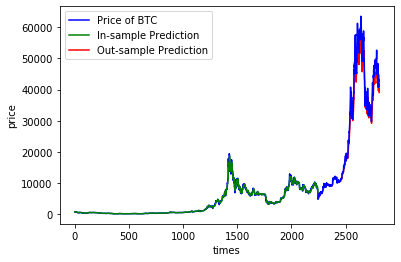

In [206]:
N_original, N_test = len(y_train_original),len(y_test_model)
index_test = [i for i in range(0,N_test)]
index_test = np.array(index_test).reshape(-1,1) + N_original
## Show all curve
plt.plot(y_train_original, color = 'blue', label = 'Price of BTC')
plt.plot(y_train_model, color = 'green', label = 'In-sample Prediction')
plt.xlabel('times')
plt.ylabel('price')
plt.plot(index_test, y_test_model, color = 'red', label = 'Out-sample Prediction')
plt.plot(index_test, y_test_original, color = 'blue', label = 'Price of BTC')
# plt.plot(index_test, y_test_model, color = 'red', label = 'Out-sample Prediction')
plt.legend(['Price of BTC','In-sample Prediction','Out-sample Prediction'])
plt.savefig("TestGRU20-1.png", dpi=500)
plt.show()
df_GRU_predict_train_20_1 = pd.DataFrame({'y_test_original':y_test_original.flatten(),'y_test_model':y_test_model.flatten()})
df_GRU_predict_train_20_1.to_csv(r"./data/df_GRU_predict_train_20_1.csv",sep=',')